<a href="https://colab.research.google.com/github/evaliza/Alien-vs-Predator-episode-4/blob/main/episode_4_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alien vs. Predator - épisode 4


## Contexte du projet 

L'épisode 3 a démontré que la technique de "transfer learning" pouvait augmenter de manière drastique les performances d'un CNN à effectuer de la classification d'images même sur un petit jeu de données. Il existe toutefois un léger sur-apprentissage résiduel. L'objectif de ce brief est de combiner la technique de "data augmentation" étudiée dans l'épisode 2 avec la technique de "features extraction" vue dans l'épisode 3 dans le but d'éliminer ce très léger sur-apprentissage résiduel ainsi que d'augmenter encore la précision du CNN.

Pour cela :

- Charger à nouveau le modèle VGG-16
  - N.B. Ne pas oublier de "freezer" VGG-16 !
- Concaténer VGG-16 avec par exemple le perceptron multi-couches suivant
​

  - model.add(layers.Dense(units=256, activation='relu', input_dim=4 * 4 * 512))

  - model.add(layers.Dense(units=1, activation='sigmoid'))

​

N.B. Notons que l'architecture de ce MLP peut être optimisée : vous pouvez notamment tester un autre nombre de neurones dans la couche cachée.

​

- Entrainer l'ensemble en utilisant la technique de "data augmentation"
  - ATTENTION AUX TEMPS DE CALCULS !!!

# Import libraries

In [ ]:
import numpy as np 
import pandas as pd

# import Keras libraries and packages
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.metrics import *
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.models import Model


import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/gdrive


# Import data

In [ ]:
path_data = '/content/drive/MyDrive/Colab Notebooks/Alien_vs_Predator/'

In [ ]:
 path_train = path_data + 'Train/'

In [ ]:
path_valid = path_data + 'Validation/'

## Data augmentation

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')


train_generator = train_datagen.flow_from_directory(path_train,
                                                    target_size=(150, 150),
                                                    batch_size=494, #full batch
                                                    class_mode='binary',
                                                    seed = 42)

Found 494 images belonging to 2 classes.


In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)


valid_generator = valid_datagen.flow_from_directory(path_valid,
                                                    target_size=(150, 150),
                                                    batch_size=494, #full batch
                                                    class_mode='binary',
                                                    seed = 42)

Found 200 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

IMG_SHAPE = (150, 150, 3)
vgg_model = VGG16(input_shape = IMG_SHAPE, include_top = False,
            weights="imagenet")


# freeze layers
for layer in vgg_model.layers:
  layer.trainable = False

# function to freeze vgg_model.trainable = False

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [ ]:
X_train_4 = train_generator[0][0]
y_train_4 = train_generator[0][1]
X_val_4 = valid_generator[0][0]
y_val_4 = valid_generator[0][1]


In [ ]:
print(X_train_4.shape) 
# 494 number of images
# 150 by 150 tensor:  size of each input image
# 3 = RGB

(494, 150, 150, 3)


In [ ]:
print(y_train_4.shape) 


(494,)


# Save features

# Training model

In [ ]:
model = Sequential() 
model.add(vgg_model)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dense(units=1, activation='sigmoid'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer = 'adam',loss = "binary_crossentropy",metrics = ['accuracy'])


In [ ]:
history = model.fit(train_generator,
                       epochs = 100,
                       steps_per_epoch =1,
                       validation_data=(valid_generator),
                       validation_steps = 1)

Epoch 1/100
1/1 [==============================] - 71s 71s/step - loss: 0.7725 - accuracy: 0.4190 - val_loss: 2.2977 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 8s 8s/step - loss: 2.2286 - accuracy: 0.5000 - val_loss: 0.9979 - val_accuracy: 0.5750
Epoch 3/100
1/1 [==============================] - 8s 8s/step - loss: 1.0834 - accuracy: 0.5709 - val_loss: 0.9474 - val_accuracy: 0.5700
Epoch 4/100
1/1 [==============================] - 8s 8s/step - loss: 1.0517 - accuracy: 0.5607 - val_loss: 0.4498 - val_accuracy: 0.7950
Epoch 5/100
1/1 [==============================] - 8s 8s/step - loss: 0.4869 - accuracy: 0.7773 - val_loss: 0.5897 - val_accuracy: 0.6450
Epoch 6/100
1/1 [==============================] - 8s 8s/step - loss: 0.5575 - accuracy: 0.7045 - val_loss: 0.7322 - val_accuracy: 0.5600
Epoch 7/100
1/1 [==============================] - 8s 8s/step - loss: 0.7245 - accuracy: 0.6073 - val_loss: 0.5533 - val_accuracy: 0.6750
Epoch 8/100
1/1 [===============

# Evaluating Train & Validation

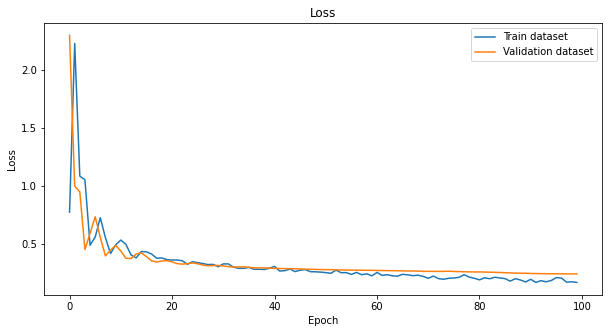

In [ ]:
plt.figure(figsize =(10, 5))
plt.title('Loss')
plt.plot(history.history['loss'], label='Train dataset')
plt.plot(history.history['val_loss'], label='Validation dataset')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

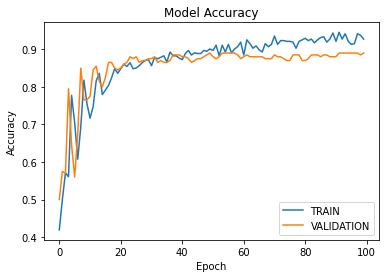

In [ ]:
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'], label='TRAIN')
plt.plot(history.history['val_accuracy'], label='VALIDATION')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# training evaluation
y_pred_train = (model.predict(X_train_4)> 0.5).astype('int32')
accuracy_train = tf.keras.metrics.BinaryAccuracy()
accuracy_train.update_state(y_train_4, y_pred_train)
print('Accuracy score : {}'.format(accuracy_train.result().numpy()))

Accuracy score : 0.9352226853370667


In [ ]:
# validation evaluation
y_pred_val = (model.predict(X_val_4)> 0.5).astype('int32')
accuracy_val = tf.keras.metrics.BinaryAccuracy()
accuracy_val.update_state(y_val_4, y_pred_val)
print('Accuracy score : {}'.format(accuracy_val.result().numpy()))

Accuracy score : 0.8899999856948853


In [ ]:
cm_train = tf.math.confusion_matrix(y_train_4, y_pred_train).numpy()

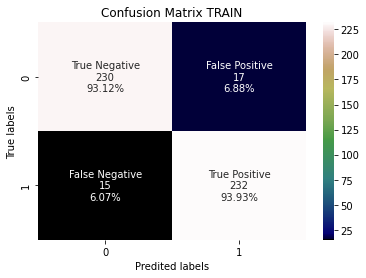

In [ ]:
ax= plt.subplot()

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in cm_train.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in (cm_train/np.sum(cm_train, axis=1)).flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip (group_names, group_counts, group_percentages)]
labels = np.array(labels).reshape(2,2)

sns.heatmap(cm_train, annot=labels, fmt="", cmap="gist_earth")

ax.set_xlabel("Predited labels")
ax.set_ylabel("True labels") 
ax.set_title("Confusion Matrix TRAIN") 

plt.show()

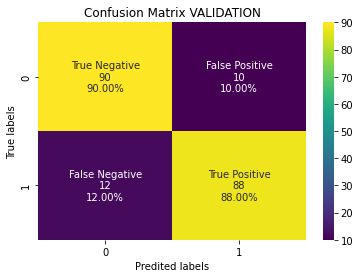

In [ ]:
cm_val = tf.math.confusion_matrix(y_val_4, y_pred_val).numpy()

ax= plt.subplot()

group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in cm_val.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in (cm_val/np.sum(cm_val, axis=1)).flatten()]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip (group_names, group_counts, group_percentages)]
labels = np.array(labels).reshape(2,2)

sns.heatmap(cm_val, annot=labels, fmt="", cmap="viridis")

ax.set_xlabel("Predited labels")
ax.set_ylabel("True labels") 
ax.set_title("Confusion Matrix VALIDATION") 

plt.show()

## Save model

In [ ]:

model.save('/content/drive/MyDrive/Colab Notebooks/Alien_vs_Predator/' + 'model_ep4')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Alien_vs_Predator/model_ep4/assets


In [ ]:
#model.save("episode4_model")
#model.save('/Alien_vs_Predator/episode4_model)
#path/to/location'
#model.save('episode4_model.h5')
#model.save("episode4_model")
#filepath = 
#tf.keras.models.save_model("episode4_model")
#model.save('/content/drive/MyDrive/Colab Notebooks/2022_02_08_ep4_Alien_Predator/' + 'model_ep4')

In [ ]:
#y_pred_test = (model.predict(X_test_4)> 0.5).astype('int32')
#accuracy_test = tf.keras.metrics.BinaryAccuracy()
#accuracy_test.update_state(y_test_4, y_pred_test)
#print('Accuracy score : {}'.format(accuracy_test.result().numpy()))